In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/xyzeq/'

### Load in the denoised 10x data

For some reason, the `h5` that I got from Derek had some issues, it was only reading it as a `view` and not an `actual`. I loaded it in and fixed it, and re-exported for easier loading later. 

In [185]:
# warnings.filterwarnings('ignore')
# liver1_denoised = sc.read_10x_h5(prefix + '10x/20191102/cellbender/output/Liver1_raw_feature_bc_matrix.denoised.h5')
# sc.utils.view_to_actual(liver1_denoised)
# liver1_denoised.var_names_make_unique()
# warnings.filterwarnings('default')
# liver1_denoised.write_h5ad(prefix + '10x/20191102/cellbender/output/Liver1_raw_feature_bc_matrix.denoised.stable.h5ad')
liver1_denoised = sc.read_h5ad(prefix + '10x/20191102/cellbender/output/Liver1_raw_feature_bc_matrix.denoised.stable.h5ad')

Visualize the knee plot to draw a cutoff for the 10x cells. There was high background in this data.

In [186]:
sc.pp.filter_cells(liver1_denoised, min_counts=0)

In [187]:
liver1_denoised = liver1_denoised[liver1_denoised.obs['n_counts'] > 0].copy()

In [188]:
vals = liver1_denoised.obs['n_counts'].sort_values(ascending=False).values

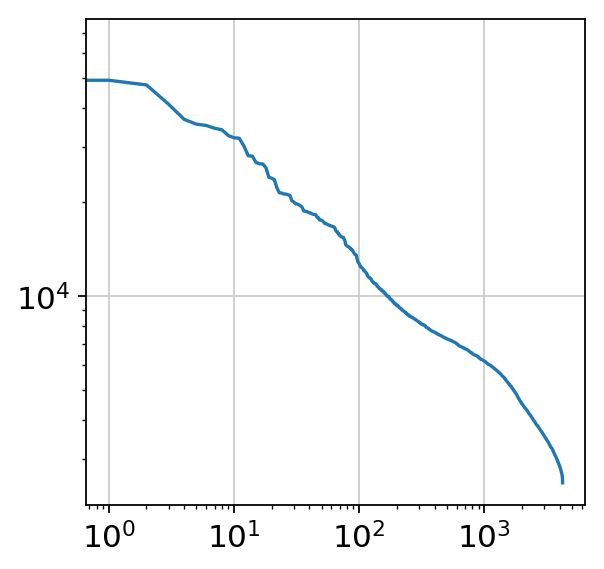

In [192]:
plt.plot(vals)
plt.xscale('log')
plt.yscale('log')

In [190]:
genelist = liver1_denoised.var_names.tolist()
mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]
mito_counts = np.ravel(np.sum(liver1_denoised[:, mito_genes].X, axis=1))

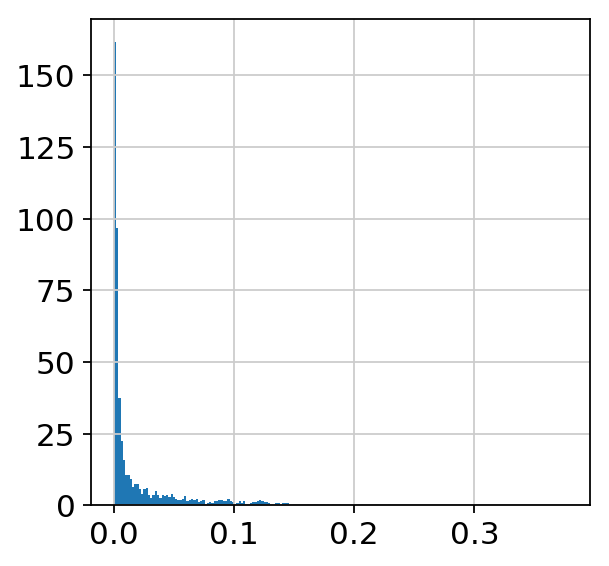

In [191]:
liver1_denoised.obs['percent_mito'] = mito_counts / liver1_denoised.obs['n_counts'].values
plt.hist(liver1_denoised.obs['percent_mito'].values,bins=200,density=True);

In [193]:
liver1_denoised = liver1_denoised[liver1_denoised.obs['percent_mito'] < 0.15].copy()

In [194]:
liver1_denoised.shape

(4105, 28692)

Looks like after denoising, we get more cells.

In [195]:
sc.pp.filter_genes(liver1_denoised, min_counts=0)

In [196]:
liver1_denoised = liver1_denoised[:, liver1_denoised.var['n_counts'] > 0].copy()

In [197]:
vals = liver1_denoised.var['n_counts'].sort_values(ascending=False).values

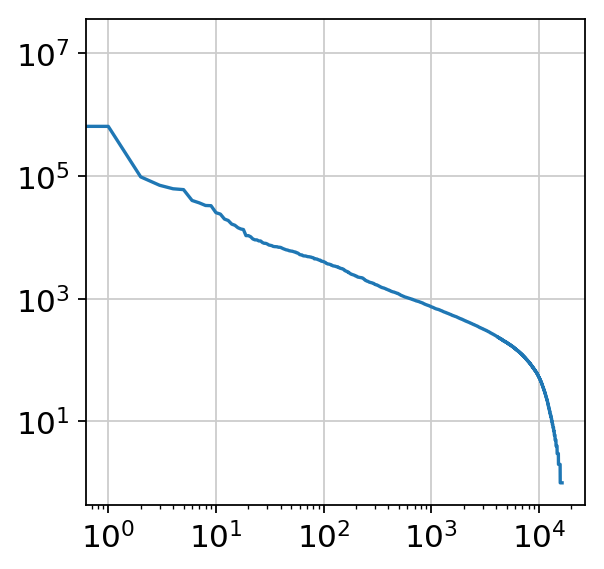

In [198]:
plt.plot(vals)
plt.xscale('log')
plt.yscale('log')

In [199]:
gene_number = 1e4
liver1_denoised = liver1_denoised[:,liver1_denoised.var['n_counts'].sort_values(ascending=False)[:int(gene_number)].index.values].copy()

In [200]:
sc.pp.log1p(liver1_denoised)
sc.pp.normalize_per_cell(liver1_denoised, counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [201]:
liver1_denoised_unscaled = liver1_denoised.copy()

### Dimensionality Reduction and Clustering

In [202]:
sc.pp.scale(liver1_denoised)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:02)


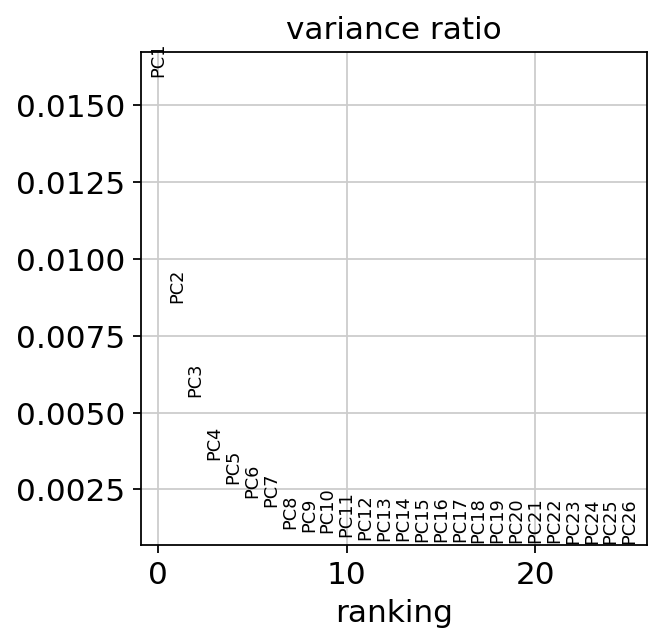

In [203]:
warnings.filterwarnings('ignore')
sc.pp.pca(liver1_denoised,n_comps=100)
sc.pl.pca_variance_ratio(liver1_denoised,log=False, n_pcs=25)
warnings.filterwarnings('default')

In [284]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(liver1_denoised,n_neighbors=15,n_pcs=10) # numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [288]:
sc.tl.umap(liver1_denoised)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [286]:
sc.tl.leiden(liver1_denoised,resolution=0.4)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


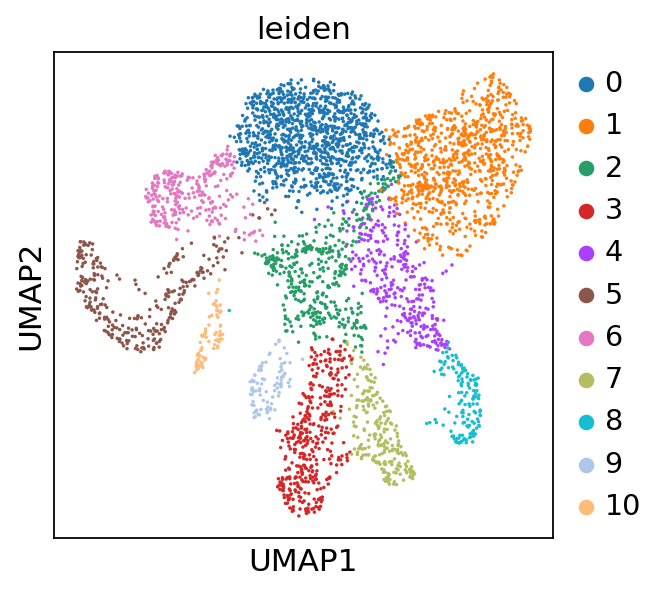

In [289]:
sc.pl.umap(liver1_denoised,color=['leiden'], size=10)

Wow, unfortunately that doens't look  as good as just the regular analysis, taking the top 2500 cells. Granted we do have more cells here. Cluster 2 just looks like ambient still. I wonder where it sits on the ranked UMI plot.

In [281]:
ranked_bcs = liver1_denoised.obs['n_counts'].sort_values().index
ranked_bcs = pd.Series(data=range(len(ranked_bcs)), index=ranked_bcs)
liver1_denoised.obs['ranked_bcs'] = ranked_bcs

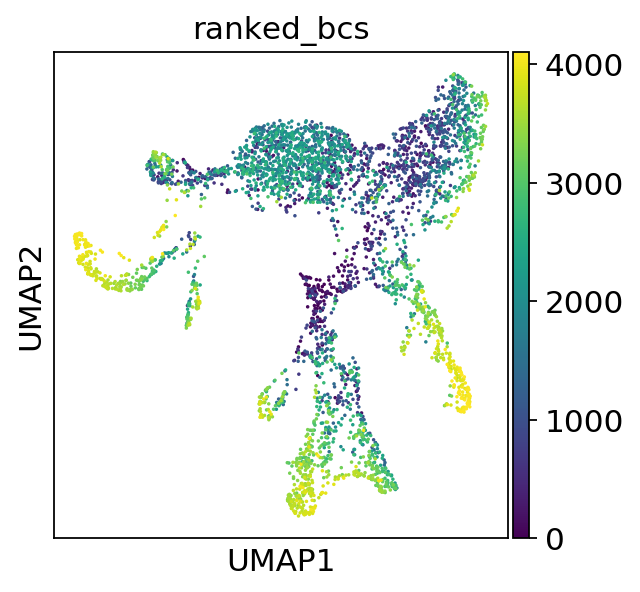

In [282]:
sc.pl.umap(liver1_denoised,color=['ranked_bcs'], size=10)

Yup, as I suspected, it just took more drops from the plateau, and unfortunately the background subtraction didn't seem to help them that much.

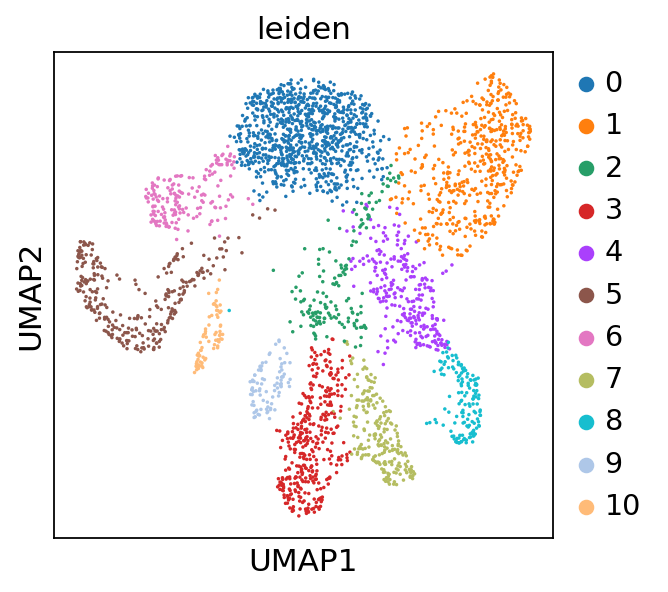

In [254]:
sc.pl.umap(liver1_denoised[liver1_denoised.obs['ranked_bcs'] > 1000],color=['leiden'], size=10)

Looks like it would be mostly gone if I just drop the lowest 1000 bcs. This would still leave us with more cells total than the non-background-removed analysis. But I'm not really aiming for more cells here, just cleaner populations, and I think even with removing those it wouldn't clean this up a whole lot.

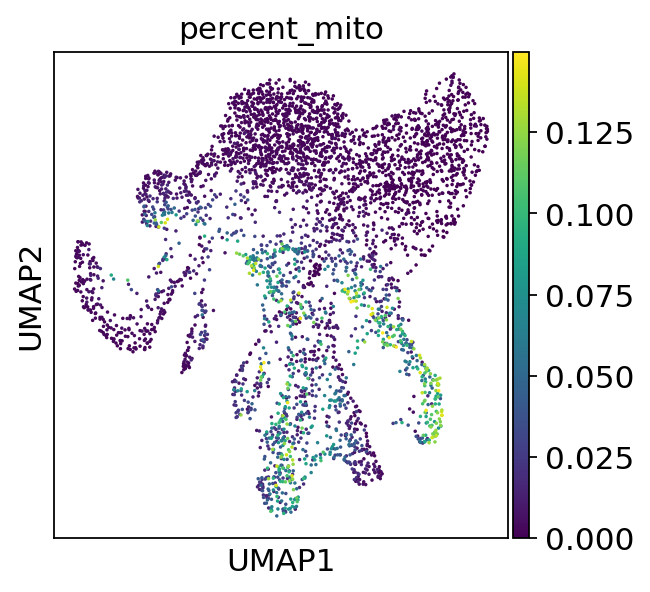

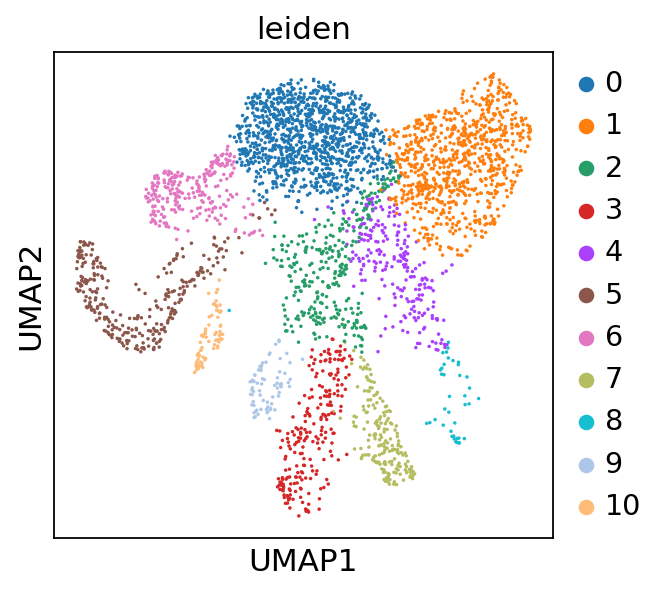

In [264]:
sc.pl.umap(liver1_denoised, color=['percent_mito'], size=10) 
sc.pl.umap(liver1_denoised[liver1_denoised.obs['percent_mito'] < 0.05] ,color=['leiden'], size=10) 

This is just to show that we can't do a percent_mito cutoff because although it would get rid of some of cluster 2, it would also get rid of some of cluster 8 which, I think, is a real population.

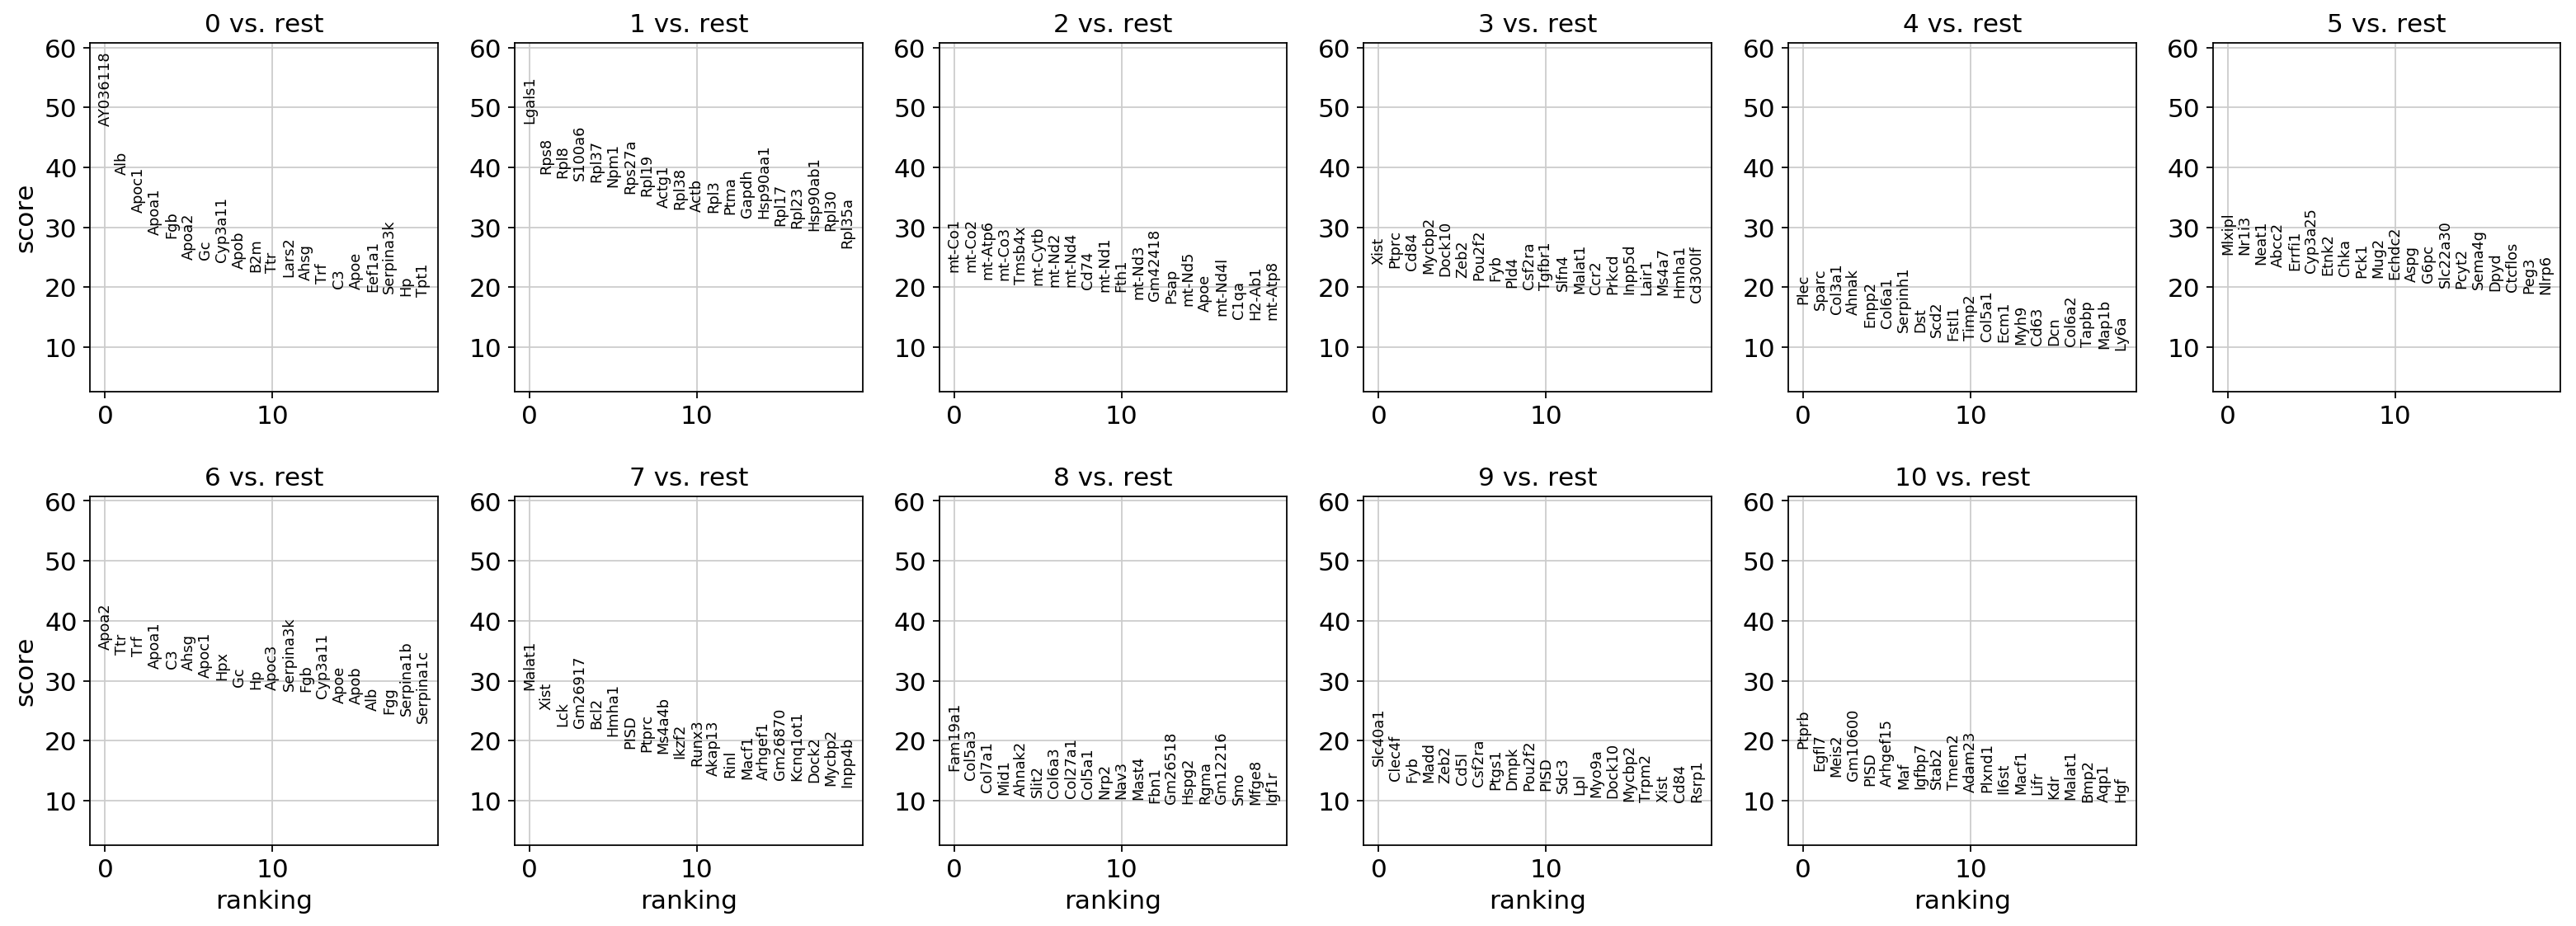

In [252]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(liver1_denoised, groupby='leiden', n_genes=200)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(liver1_denoised, ncols=6)
sc.settings.verbosity = 3

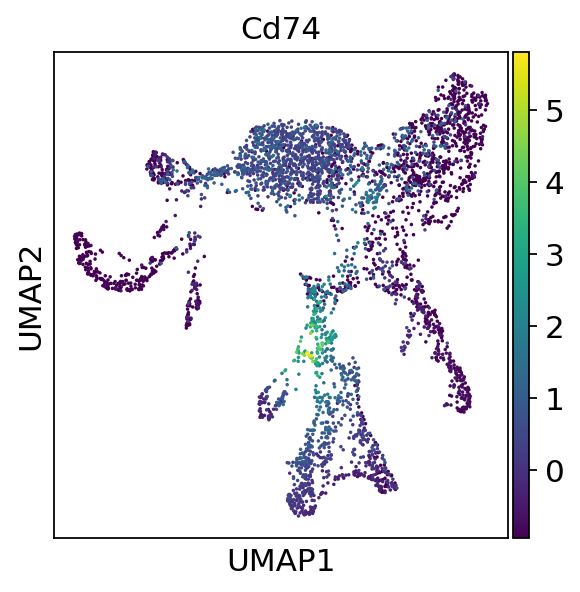

In [283]:
sc.pl.umap(liver1_denoised,color=['Cd74'], size=10) 

Maybe running doublet finder to get rid of those? That's just more processing, which I'd want to avoid doing. However, this is *more consitent* with the XYZeq analysis, because from what we've seen so far, it does exhibit that ambient population, and this does recover more cells in the cluster marked by Lgals1, but maybe running cellbender on that would get rid of it?

In [229]:
# warnings.filterwarnings('ignore')
# liver1_denoised_filt = sc.read_10x_h5(prefix + '10x/20191102/cellbender/output/Liver1_raw_feature_bc_matrix.denoised_filtered.h5')
# sc.utils.view_to_actual(liver1_denoised_filt)
# liver1_denoised_filt.var_names_make_unique()
# warnings.filterwarnings('default')
# liver1_denoised_filt.write_h5ad(prefix + '10x/20191102/cellbender/output/Liver1_raw_feature_bc_matrix.denoised_filtered.h5')
liver1_denoised_filt = sc.read_h5ad(prefix + '10x/20191102/cellbender/output/Liver1_raw_feature_bc_matrix.denoised_filtered.h5')

In [233]:
sc.pp.filter_genes(liver1_denoised_filt, min_counts=0)

In [240]:
liver1_denoised_filt.var.sort_values('n_counts', ascending=False)[:20]

,gene_ids,n_counts
index,,
Gm42418,ENSMUSG00000098178,16409106.0
Malat1,ENSMUSG00000092341,656161.0
mt-Atp6,ENSMUSG00000064357,136147.0
mt-Co3,ENSMUSG00000064358,94976.0
mt-Co2,ENSMUSG00000064354,84481.0
mt-Co1,ENSMUSG00000064351,77427.0
mt-Cytb,ENSMUSG00000064370,61196.0
mt-Nd2,ENSMUSG00000064345,50000.0
mt-Nd4,ENSMUSG00000064363,44562.0
